The following procedure uses a convolution neural network to predict instruments off of relabeled training data. 

- The relabeled training data was obtained from the XgBoostRelabeler procedure, where we used an XgBoost Classifier to repredict nonmanually verified training data.

- Then, the relabeled training data was used to train a convolutional neural network. 

- Finally, the trained CNN was used to classify the test data. 

In [0]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Input, Dropout, BatchNormalization, Convolution2D, MaxPooling2D, GlobalMaxPool2D
from sklearn.model_selection import train_test_split
from random import shuffle
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import *

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Created CNN architecture:
- Used multiple convolution layers with increasing filter size
- Added L2 regularization to replace utilization of dropout in early layers
- Utilized strides to increase chunk size used by CNN
- Used softmax activation over sigmoid due to improvement in accuracy 
- learning_rate = 0.0005 balanced for convergence
- categorical_crossentropy for loss function due to multi-class problem

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 282, 426, 32)      4736      
_________________________________________________________________
activation_9 (Activation)    (None, 282, 426, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 282, 426, 32)      50208     
_________________________________________________________________
activation_10 (Activation)   (None, 282, 426, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 282, 426, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 141, 213, 32)      1056      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 71, 107, 64)      

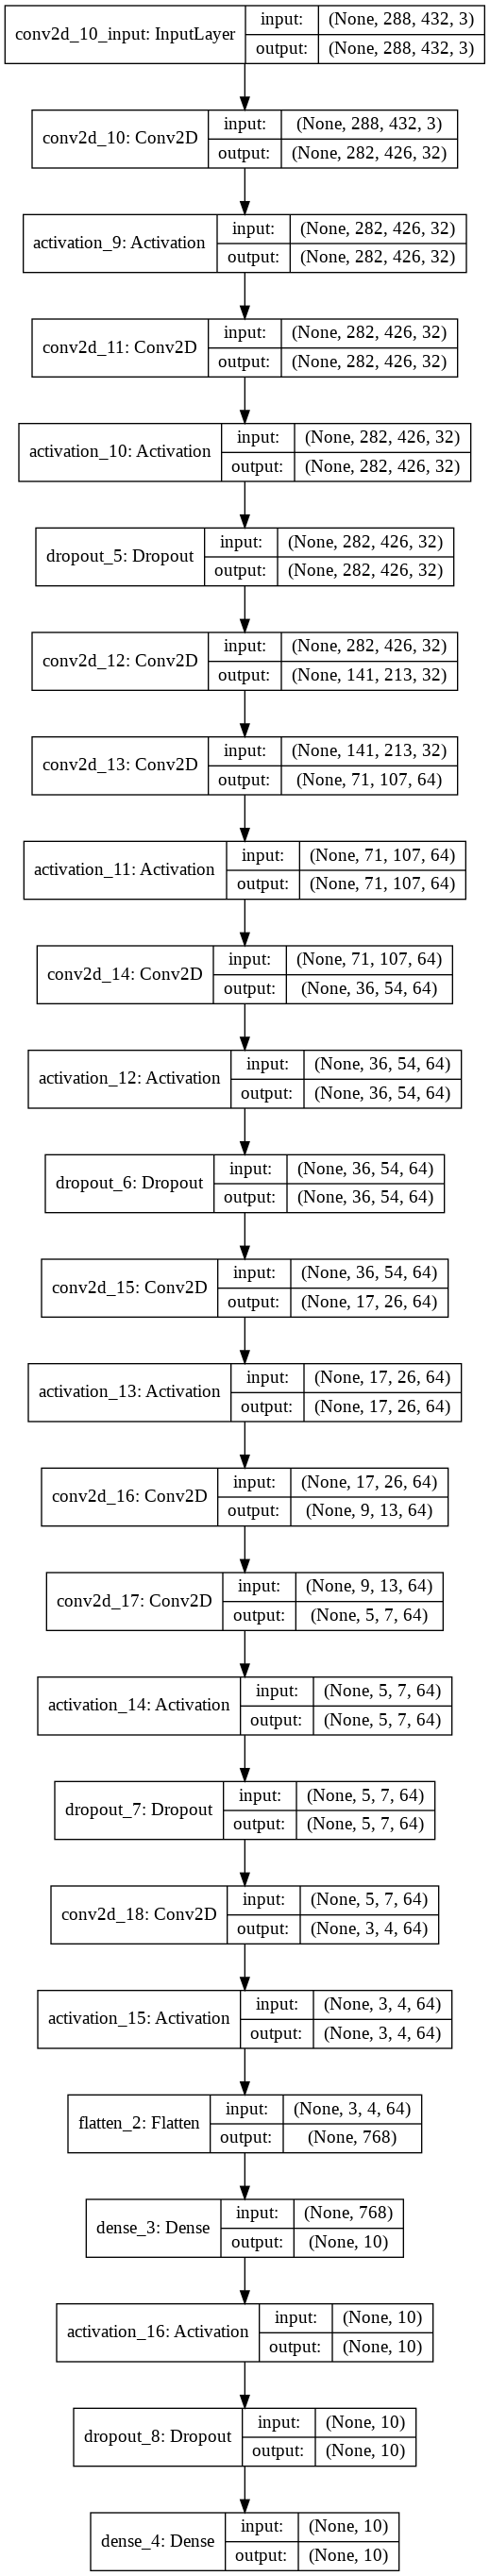

In [0]:
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.regularizers import l2
import pandas as pd
import numpy as np

## Previous architecture used

# model = Sequential()
# model.add(Conv2D(32, (7, 7), padding='valid', input_shape=(288,432,3)))
# model.add(Activation('relu'))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv2D(128, (3, 3), padding='same'), kernel_regularizer=l2(0.0005))
# model.add(Activation('relu'))
# model.add(Conv2D(128, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.5))

# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
## model.add(Dropout(0.5))

# model.add(Dense(10, activation='softmax'))
# model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["categorical_accuracy"])
# model.summary()

model = Sequential()
model.add(Conv2D(32, (7, 7), padding='valid', input_shape=(288,432,3), kernel_regularizer=l2(0.0005)))
model.add(Activation('relu'))

model.add(Conv2D(32, (7, 7), padding='same'))
model.add(Activation('relu'))

model.add(Dropout(0.25))

model.add(Conv2D(32, (1, 1), strides=(2,2), kernel_regularizer=l2(0.0005), padding='same'))

model.add(Conv2D(64, (3, 3), strides=(2,2), kernel_regularizer=l2(0.0005), padding='same'))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.35))
model.add(Conv2D(64, (3, 3), strides=(2, 2)))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (1, 1), strides=(2,2), kernel_regularizer=l2(0.0005), padding='same'))


model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.35))
model.add(Conv2D(64, (3, 3),strides=(2, 2), padding='same'))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dropout(0.35))

model.add(Dense(10, activation='softmax'))

model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
# optimizers.rmsprop(lr=0.0005, decay=1e-6) )optimizers.Adam(lr=0.00075, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.summary()
plot_model(model, to_file='/content/drive/Shared drives/301FP/Data_Folder/model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
from keras_preprocessing.image import ImageDataGenerator
# quick function to change ending labels for the file names
def append_ext(fn):
    return fn+".png"

In [0]:
cd /content/drive/Shared drives/301FP/Data_Folder/

/content/drive/Shared drives/301FP/Data_Folder


Load in reverified dataframe from the XGBoost reverification 

In [0]:
train = pd.read_csv('/content/drive/Shared drives/301FP/Data_Folder/Reverified_XGboostCV.csv',dtype=str)
train["fname"] = train["fname"].str[:-4].apply(append_ext) # changing the filenames to png

In [0]:
train.head()

,Unnamed: 0,Unnamed: 0.1,chroma_stft,fname,label,manually_verified,mfcc1,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc2,mfcc20,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,rmse,rolloff,spectral_bandwidth,spectral_centroid,zero_crossing_rate
0,1,0,0.20440595436091727,001ca53d.png,Saxophone,1,73.88207786974871,-1.915029580601592,-8.089818586751951,-0.5499569560252713,-5.4238645330027415,0.5386799424915237,-5.573923814020498,0.016405066040690162,-2.839658604060232,5.608781320891485,0.22056379680112725,27.773626202683328,4.010987789307758,-10.74694935376651,11.03761198442251,-4.838018278453661,4.092238224115404,-5.164023422553345,0.5377117268210994,-7.852135562112648,0.9232293963432312,6674.51857281395,2878.7445024067592,3013.667471167264,0.036462487311484916
1,3,0,0.279727365270529,00353774.png,Cello,1,76.19276765279005,6.339331537185839,-0.6600114823495926,4.499685242679059,-4.50890920081733,-0.8464678890391913,-4.5717691798013185,0.4935902924189233,-4.572782833773527,3.684965795286225,0.1252839382956926,25.364872434439217,4.653926803365988,-12.743591974486913,11.450991270420136,-7.044229459006758,2.2985904481052573,-5.0456846965704925,3.625584752808861,0.35208521980384466,0.9271434545516968,6702.84442608173,2805.883302948308,3245.598952406019,0.05769481169871795
2,5,0,0.6343485051473369,0048fd00.png,Gunshot_or_gunfire,1,118.43283307990806,4.273109338172453,-2.8129454025752114,2.2419198620235483,-3.316026475426633,2.4607524555856317,-3.522025536442931,1.4917780247647765,-3.584071156454963,3.0648938312921565,-3.372454029754259,78.05758100411836,1.9674537886975003,-4.067012592400679,18.778538058069667,2.8385950055911917,8.0330719969409,1.0995149086057758,5.892929841322143,-0.4193658085143572,0.9095029830932616,5560.5908203125,2703.0210578505653,2511.919458466123,0.0388671875
3,6,0,0.7857915966490475,006f2f32.png,Hi-hat,1,-206.99954558203328,8.38140549592697,6.247459649759404,6.516367905071582,4.7749445790548135,7.389406765328549,4.069200556601301,6.6732011387319,3.875314119660163,8.54483907389167,5.067238988700776,12.039480750737233,6.3908891728799295,-6.744708012883137,13.474934044348927,7.793327765304268,6.855790786562082,7.249354802332044,8.609479266825051,1.3670076887664802,0.9762598276138306,3289.5654965753424,1313.6745394083778,1658.5982101549298,0.07009177011986302
4,7,0,0.4694636874845386,0091fc7f.png,Cello,1,51.30918028886032,3.8437045139416712,-1.968391338863092,1.4590299252188748,-4.554978710150653,-0.3634835905162476,-4.066000979986529,1.3487892600817688,-2.8280708602665223,2.2693629639423505,-2.3941039726308846,64.85877090739015,1.5242712020724487,-8.277920983456415,10.714432320052204,0.7583678805391958,7.926762420175914,-0.2886308192197777,5.639803226672768,-0.4502235062610916,0.9685856699943542,4963.140720274389,2303.6686276653745,2222.079281070253,0.033685451600609755


In [0]:
ver_train = train.loc[train['manually_verified'] == '1']
train_train = train.loc[train['manually_verified'] == '0']

In [0]:
ver_train.head()

,Unnamed: 0,Unnamed: 0.1,chroma_stft,fname,label,manually_verified,mfcc1,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc2,mfcc20,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,rmse,rolloff,spectral_bandwidth,spectral_centroid,zero_crossing_rate
0,1,0,0.20440595436091727,001ca53d.png,Saxophone,1,73.88207786974871,-1.915029580601592,-8.089818586751951,-0.5499569560252713,-5.4238645330027415,0.5386799424915237,-5.573923814020498,0.016405066040690162,-2.839658604060232,5.608781320891485,0.22056379680112725,27.773626202683328,4.010987789307758,-10.74694935376651,11.03761198442251,-4.838018278453661,4.092238224115404,-5.164023422553345,0.5377117268210994,-7.852135562112648,0.9232293963432312,6674.51857281395,2878.7445024067592,3013.667471167264,0.036462487311484916
1,3,0,0.279727365270529,00353774.png,Cello,1,76.19276765279005,6.339331537185839,-0.6600114823495926,4.499685242679059,-4.50890920081733,-0.8464678890391913,-4.5717691798013185,0.4935902924189233,-4.572782833773527,3.684965795286225,0.1252839382956926,25.364872434439217,4.653926803365988,-12.743591974486913,11.450991270420136,-7.044229459006758,2.2985904481052573,-5.0456846965704925,3.625584752808861,0.35208521980384466,0.9271434545516968,6702.84442608173,2805.883302948308,3245.598952406019,0.05769481169871795
2,5,0,0.6343485051473369,0048fd00.png,Gunshot_or_gunfire,1,118.43283307990806,4.273109338172453,-2.8129454025752114,2.2419198620235483,-3.316026475426633,2.4607524555856317,-3.522025536442931,1.4917780247647765,-3.584071156454963,3.0648938312921565,-3.372454029754259,78.05758100411836,1.9674537886975003,-4.067012592400679,18.778538058069667,2.8385950055911917,8.0330719969409,1.0995149086057758,5.892929841322143,-0.4193658085143572,0.9095029830932616,5560.5908203125,2703.0210578505653,2511.919458466123,0.0388671875
3,6,0,0.7857915966490475,006f2f32.png,Hi-hat,1,-206.99954558203328,8.38140549592697,6.247459649759404,6.516367905071582,4.7749445790548135,7.389406765328549,4.069200556601301,6.6732011387319,3.875314119660163,8.54483907389167,5.067238988700776,12.039480750737233,6.3908891728799295,-6.744708012883137,13.474934044348927,7.793327765304268,6.855790786562082,7.249354802332044,8.609479266825051,1.3670076887664802,0.9762598276138306,3289.5654965753424,1313.6745394083778,1658.5982101549298,0.07009177011986302
4,7,0,0.4694636874845386,0091fc7f.png,Cello,1,51.30918028886032,3.8437045139416712,-1.968391338863092,1.4590299252188748,-4.554978710150653,-0.3634835905162476,-4.066000979986529,1.3487892600817688,-2.8280708602665223,2.2693629639423505,-2.3941039726308846,64.85877090739015,1.5242712020724487,-8.277920983456415,10.714432320052204,0.7583678805391958,7.926762420175914,-0.2886308192197777,5.639803226672768,-0.4502235062610916,0.9685856699943542,4963.140720274389,2303.6686276653745,2222.079281070253,0.033685451600609755


In [0]:
datagen = ImageDataGenerator(rescale=1./255.) 

In [0]:
cd /content/drive/Shared drives/301FP/unzipped/train_img_original2/

/content/drive/Shared drives/301FP/unzipped/train_img_original2


In [0]:
listOfFiles = os.listdir('/content/drive/Shared drives/301FP/unzipped/train_img_original2/')
print(len(listOfFiles))

2757


Create train and validation generators for the CNN

In [0]:
train_generator=datagen.flow_from_dataframe(
    dataframe = train_train,
    directory="/content/drive/Shared drives/301FP/unzipped/train_img_original2/",
    x_col="fname",
    y_col="label",
    subset="training",
    batch_size=64,
    seed=1,
    shuffle=True,
    class_mode="categorical",
    target_size=(288,432))

Found 1501 validated image filenames belonging to 10 classes.


In [0]:
valid_generator=datagen.flow_from_dataframe(
    dataframe = ver_train,
    directory="/content/drive/Shared drives/301FP/unzipped/train_img_original2/",
    x_col="fname",
    y_col="label",
    subset="training",
    batch_size=64,
    seed=1,
    shuffle=True,
    class_mode="categorical",
    target_size=(288,432))

Found 1256 validated image filenames belonging to 10 classes.


In [0]:
ss_train = train_generator.n//train_generator.batch_size

In [0]:
ss_valid = valid_generator.n//valid_generator.batch_size

In [0]:
model.fit_generator(generator = train_generator, steps_per_epoch=ss_train, epochs=40)

In [0]:
model.fit_generator(generator = valid_generator, steps_per_epoch=ss_valid, epochs=30)

In [0]:
listOfFiles = os.listdir('/content/drive/Shared drives/301FP/unzipped/test_img_raw/')

In [0]:
testdf = pd.DataFrame()

In [0]:
testdf['fname'] = listOfFiles

In [0]:
len(testdf)

In [0]:
testdf.head()

In [0]:
test_datagenerator = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagenerator.flow_from_dataframe(
    dataframe=testdf,
    directory="/content/drive/Shared drives/301FP/unzipped/test_img_raw/",
    x_col="fname",
    y_col=None,
    batch_size=64,
    seed=1,
    shuffle=False,
    class_mode=None,
    target_size=(288,432))

ss_test = test_generator.n//test_generator.batch_size + 1 # need to add one to get all test images to be predicted

In [0]:
cd /content/drive/Shared drives/301FP/unzipped/test_img_raw

In [0]:
test_generator.reset()
pred=model.predict_generator(test_generator,steps=ss_test,verbose=1)

In [0]:
len(pred)

In [0]:
fnames = testdf['fname']

In [0]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_class_indices = np.argmax(pred,axis=1)
predictions = [labels[k] for k in predicted_class_indices]
print(predictions)

In [0]:
testdf

Creating Submission Frame

In [0]:
testdf['label'] = predictions

In [0]:
testdf.head(1)

In [0]:
def append_ext2(fn):
  return fn+".wav"
testdf['fname'] = testdf['fname'].str[:-4].apply(append_ext2)


In [0]:
testdf.head()

In [0]:
# testdf.to_csv('/content/drive/Shared drives/301FP/Data_Folder/cnn_predictions.csv', index=False)

In [0]:
# testdf = pd.read_csv('/content/drive/Shared drives/301FP/Data_Folder/cnn_predictions.csv')

In [0]:
testdf = testdf.set_index('fname')

In [0]:
testdf.head()

In [0]:
testdf.to_csv('/content/drive/Shared drives/301FP/Data_Folder/cnn_pred_long_Retry_XGpre18.csv')